<a href="https://colab.research.google.com/github/mmalam3/LSTM-RNN-Optimal-Data-Sequence-Generation/blob/main/LSTM_RNN_Data_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing neccessary libraries and packages

In [11]:
# import tensorflow
import tensorflow as tf

# import relevance python ML libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import other python libraries
import os
import glob

## Accessing data sequences

First, let's start with the definition of a method `read_data(`) to access all our input data sequences. Each of our input data sequence contains categorical data preprocessed earlier. These sequences were extracted from the PEEVES dataset: https://ora.ox.ac.uk/objects/uuid:75726ff7-fee1-420d-8a17-de9572324c7d. We are particularly interested in the data sequences presented in the `event_value` column because this column records the actual occurrences of different IoT events in a smart home captured in the dataset.   

In [12]:
# ********* Method to access data files ***********
# *************************************************

# Read the dataset
def read_data(file_path):
    dfs = pd.DataFrame()

    # Retrieve all CSV file from 'sample_data' folder
    file_names = glob.glob(file_path + '*.csv')

    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs = pd.concat([dfs, df], ignore_index=True)
        del df

    # Remove the '_' (uderscore) with from 'event_value' column
    dfs['event_value'] = dfs['event_value'].str.replace('_', '')

    return dfs

## Generating corpus
Now, we define the method `generate_corpus()` to create a corpus containing all the input sequences .

In [13]:
# ********** Method to generate corpus from the dataframe **************
# **********************************************************************

def generate_corpus(df, sentence_size):
    # Data Preprocessing
    corpus_ = df['event_value'].values.flatten()

    corpus = []
    sentence_size = sentence_size
    count = 0
    temp_sentence = ''

    for item in corpus_:
        count += 1
        if count < sentence_size:
            temp_sentence += item + ' '
        else:
            temp_sentence += item
            corpus.append(temp_sentence)
            temp_sentence = ''
            count = 0

    return corpus

## Preparing train and validation sets

We split the corpus into two datasets: *train* set and *validation* set. We use the `train_val_split()` method to perform the task given a user input `training_split` where the user defines what percentange of data from the corpus is to used as training data.

In [14]:
# ************* Method to split train and validation sets *********************
# *****************************************************************************

def train_val_split(sentences, training_split):
    # compute the number (an integer) of sentences that will be used for training
    train_size = int(len(sentences) * training_split)

    # split the sentences and labels into train/validation splits
    train_sentences = sentences[0:train_size]
    validation_sentences = sentences[train_size:]

    return train_sentences, validation_sentences


## Creating and fitting a tokenizer

We create a `tokenizer` using the `tf.keras.preprocessing.text.Tokenizer(`) method and fit the tokenizer on the training data using `fit_on_texts()` method.

In [15]:
# ********** Method to return a tokenizer fitted into train_sentences ***************
# ***********************************************************************************

def fit_tokenizer(train_sentences):
    # Create tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(train_sentences)

    # Define the total words. Add 1 for the index `0` which is just the padding token.
    total_words = len(tokenizer.word_index) + 1

    return tokenizer, total_words

## Vectorizing, padding, and creating n_grams

In the  `data_preprocessing()` method, we perform the following tasks:

*   Vectorizing text corpus using the `texts_to_sequences(`) method of TensorFlow
*   Generating subsequences form the sentences i.e., creating `n_grams`, and
*   Trasnforming all sentences into same-length NumPy array using the `tf.keras.preprocessing.sequence.pad_sequences` method

In [16]:
# ******* Method to return padded sequences and labels ************************
# *****************************************************************************
def data_preprocessing(sentences, tokenizer, total_words):
    # Initialize the sequences list
    input_sequences = []

    # Loop over the line several times to generate the subphrases
    for line in sentences:
        # Tokenize the current line
        token_list = tokenizer.texts_to_sequences([line])[0]

        for i in range(1, len(token_list)):
            # Generate the subphrase
            n_gram_sequence = token_list[:i + 1]

            # Append the subphrase to the sequences list
            input_sequences.append(n_gram_sequence)

    # Get the length of the longest line
    max_sequence_len = max([len(x) for x in input_sequences])

    padded_sequenes = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
    # Pad all sequences
    input_sequences = np.array(padded_sequenes)

    # Create inputs and label by splitting the last token in the subphrases
    xs, labels = input_sequences[:, :-1], input_sequences[:, -1]

    # Convert the label into one-hot arrays
    ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

    return xs, ys, max_sequence_len

## Building the LSTM neural network

Now, we build and compile an LSTM-based recurrent neural network (RNN) with `Adam` as the optimizer and `categorical_crossentropy` as the loss function.

In [17]:
# ************** Method to build the neural network model *********************
# *****************************************************************************

# Build the model
def build_model(max_sequence_len, total_words):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(total_words, 128, input_length=max_sequence_len - 1),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(total_words, activation='softmax')
    ])

    # Use categorical crossentropy because this is a multi-class problem
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    print('\nModel Summary:')
    model.summary()

    return model

## Generating optimal data sequences

Once the RNN is trained, we use the following `predict_text()` method to generate an optimal sequence of unique nodes given a user-defined *seed*. This *seed* is the first node in the predicted data sequence.

In [18]:

# ******************** Method to predict next words ***************************
# *****************************************************************************

def predict_text(seed, tokenizer, model, max_sequence_len, next_words):
    # Define seed text
    seed_text = seed
    prediction = [seed_text]

    # Define total words to predict
    next_words = next_words

    # Loop until desired length is reached
    for _ in range(next_words):

        # Convert the seed text to a token sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad the sequence
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

        # Feed to the model and get the probabilities for each index
        probabilities = model.predict(token_list)

        # Get the index with the highest probability
        predicted = np.argmax(probabilities, axis=-1)[0]

        # Ignore if index is 0 because that is just the padding.
        if predicted != 0:
            # Look up the word associated with the index.
            output_word = tokenizer.index_word[predicted]

            # Combine with the seed text
            seed_text += " " + output_word
            prediction.append(output_word)

    prediction_unique = []
    for item in prediction:
        if item not in prediction_unique:
            # append only the unique words
            prediction_unique.append(item)

    return prediction, prediction_unique

## Defining callbacks

We define two callbacks:

1.   `ModelCheckpoint()` to save the model's weights every 50 timsteps at each epoch
2.   `myCallback()` to stop training the model once the model accuracy reaches beyond 99.97%



In [44]:
# checkpoint path to save model weights during training
checkpoint_path = "models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 50 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,
                                                 save_weights_only=True,
                                                 save_freq=50)

# Create a callback that stops training the model once a certain accuracy threshold is reached
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.997):
          print("\nReached 99.70% accuracy, so stopping training!!")
          self.model.stop_training = True

## Model training

Finally, we invoke all the previously defined tasks and train the RNN using a `fit()` method. We *can* also set the user-defined hyperparamter here.

In [45]:
# Read the data
file_path = os.path.join(os.getcwd(), 'data/')
df = read_data(file_path)

# generate the corpus
sentence_size = 227
sentences = generate_corpus(df, sentence_size)

# set the split size and split the corpus
training_split = 0.8
train_sentences, validation_sentences = train_val_split(sentences, training_split)

# get a fitted tokenizer and the tota number of words in the vocab
tokenizer, total_words = fit_tokenizer(train_sentences)

# get processed and padded sequences for both train_sentences and validation_sentences
X_train, y_train, max_sequence_len = data_preprocessing(train_sentences, tokenizer, total_words)
X_valid, y_valid, max_sequence_len = data_preprocessing(validation_sentences, tokenizer, total_words)

# get the neural network model
model = build_model(max_sequence_len, total_words)

# set hyperparameters
epochs = 50
next_words = 100
seed = 'cam_on'

# Train the model
print('\nTraining Time!')
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[cp_callback, myCallback()])


Model Summary:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 226, 128)          2944      
                                                                 
 bidirectional_14 (Bidirect  (None, 226, 128)          98816     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_7 (Dense)             (None, 23)                1495      
                                                                 
Total params: 144471 (564.34 KB)
Trainable params: 144471 (564.34 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________

## Evaluating training performances

We use the following `evaluate_model_accuracy()` and `evaluate_model_loss()` methods to evaluate model **accuracy** and **loss**. We also plot corresponding figures to visually show the accuracy and loss trends.

In [46]:
# *************** Method to evaluate accuracy ************************
# ********************************************************************
def evaluate_model_accuracy(history):
    # Check how accuracy and loss changes over the training epochs

    epoch_accuracy = history.history['accuracy']
    epoch_val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(6, 4))

    plt.subplot(1, 1, 1)
    plt.plot(range(0, len(epoch_accuracy)), epoch_accuracy, 'b-', linewidth=1, label='Training Accuracy')
    plt.plot(range(0, len(epoch_val_accuracy)), epoch_val_accuracy, 'r-', linewidth=1, label='Validation Accuracy')
#     plt.title('a) Training & validation accuracy over epochs', loc='center', pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='best')

    # Enabling both grid lines:
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.5)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.9)
    plt.minorticks_on()
    plt.tick_params(which="minor", bottom=False, left=False)

    # plt.savefig("latest_result/temp/accuracy_plot.pdf", bbox_inches='tight')
    plt.show()
    plt.close()


# *********************************** Method to evaluate loss **************************************
# ****************************************************************************************************************
def evaluate_model_loss(history):
    # Check how loss changes over the training epochs
    epoch_loss = history.history['loss']
    epoch_val_loss = history.history['val_loss']

    plt.figure(figsize=(6, 4))
    plt.subplot(1, 1, 1)
    plt.plot(range(0, len(epoch_loss)), epoch_loss, 'b-', linewidth=1, label='Training Loss')
    plt.plot(range(0, len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=1, label='Validation Loss')
#     plt.title('Training & validation loss over epochs', loc='center', pad=20 )
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='best')

    # Enabling both grid lines:
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth=0.6, alpha=0.5)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.9)
    plt.minorticks_on()
    plt.tick_params(which="minor", bottom=False, left=False)

    # plt.savefig("latest_result/temp/loss_plot.pdf", bbox_inches='tight')
    plt.show()
    plt.close()

The call to the `evaluate_model_accuracy()` and `evaluate_model_loss()` methods give us the plots to see the model accuracy and loss over 100 epochs.

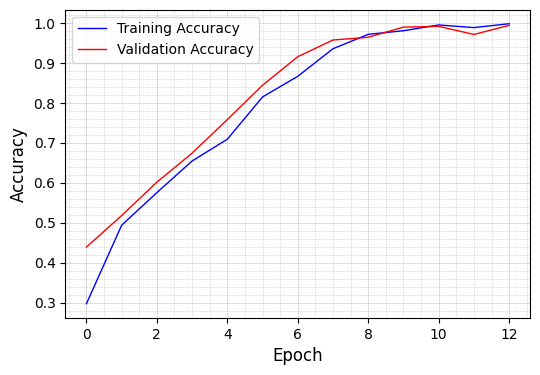

In [48]:
# check how accuracy & loss changes over epochs during the training process
evaluate_model_accuracy(history)

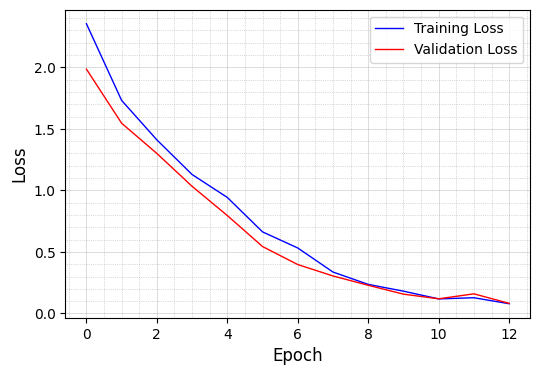

In [49]:
evaluate_model_loss(history)

## Predicting optimal data sequences

As the model is trained, now, we call the `predict_text()` method to generate an optimal data sequence given a seed.

In [50]:
# set the seed and number of words to be generated
seed = 'cam_on'
next_words = 100

sequence_predicted, sequence_predicted_unique = predict_text(seed, tokenizer, model, max_sequence_len, next_words)

print('Sequence generated with duplicate nodes: \n\n', sequence_predicted)
print('\n\nSequence generated with unique nodes: \n\n', sequence_predicted_unique)

1/1 [==============================] - 0s 130ms/step
Sequence generated with duplicate nodes: 

 ['cam_on', 'scron', 'fanoff', 'fanon', 'fanoff', 'scroff', 'camoff', 'fanon', 'fanoff', 'scron', 'fanon', 'scroff', 'fanoff', 'camon', 'pcoff', 'scroff', 'fanon', 'fanoff', 'fanon', 'fanoff', 'camoff', 'fanon', 'fanoff', 'fanon', 'fanoff', 'camon', 'fanon', 'pcon', 'scron', 'fanoff', 'fanon', 'scroff', 'fanoff', 'dooron', 'lighton', 'lightoff', 'dooroff', 'camoff', 'fanon', 'scron', 'fanoff', 'fanon', 'fanoff', 'scroff', 'camon', 'fanon', 'fanoff', 'pcoff', 'scroff', 'radon', 'fanon', 'shddown', 'fanoff', 'radoff', 'camoff', 'fanon', 'fanoff', 'shdup', 'fanon', 'fanoff', 'shddown', 'camon', 'pcon', 'scron', 'fanon', 'fanoff', 'shdup', 'scroff', 'shddown', 'camoff', 'shdup', 'dooron', 'lighton', 'dooroff', 'scron', 'rang', 'dooron', 'dooroff', 'win2on', 'win2off', 'shddown', 'fridgeon', 'fridgeoff', 'scroff', 'shdup', 'camon', 'fanon', 'fanoff', 'dooron', 'dooroff', 'pcoff', 'scroff', 'dooro

## Saving the model

Eventually, we save the trained model as a keras file.

In [51]:
model.save('models/trained_model.keras')